In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix

# Preprocessing Steps

1. Prepare dataset: add class to indicate if the piece is real or fake news

2. Tokenization to create a bag of words: remain only alphabetical lower case words

3. Lemmatization/Stemming: shorten words

4. Removing stopwords

## Prepare dataset

In [2]:
fake = pd.read_csv('Fake.csv')
real = pd.read_csv('True.csv')
fake['class'] = 1
real['class'] = 0
data = pd.concat([fake, real], axis=0).reset_index()

In [3]:
data.head(5)

,index,title,text,subject,date,class
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


## Train Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size=0.33, random_state=7406)

## Preprocessing

1. lowercase
2. remain only words, not numbers

In [5]:
def preprocessing(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

### Word Vectorization using count

In [17]:
# define stopwords
stop_words = ENGLISH_STOP_WORDS
# create CountVectorizer class
count_vectorizer = CountVectorizer(max_features=7000, stop_words = stop_words, preprocessor = preprocessing)
# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

In [18]:
count_df = pd.DataFrame(count_train.toarray(), columns=count_vectorizer.get_feature_names())

### Word Vectorization using Term Frequency - Inverse Document Frequency

In [19]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=7000, stop_words = stop_words, preprocessor = preprocessing)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [20]:
tfidf_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names())

#### check if the count vectorization returns same features as tfidf

In [24]:
# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

set()


## Trying out some classifiers

In [44]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred_nb = nb_classifier.predict(count_test)
accuracy_score(y_test, pred_nb)

0.9435783221974758

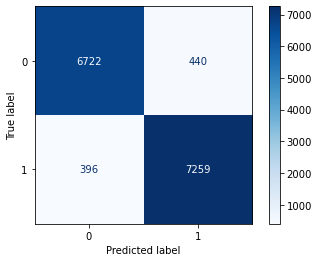

In [45]:
plot_confusion_matrix(nb_classifier, count_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [46]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)
pred_nb_tfidf = nb_classifier.predict(tfidf_test)
accuracy_score(y_test, pred_nb_tfidf)

0.9277181615711683

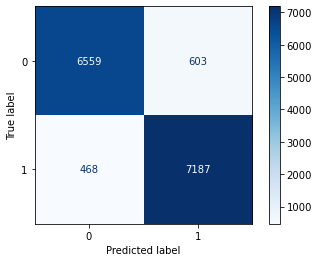

In [47]:
plot_confusion_matrix(nb_classifier, tfidf_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [48]:
lg_classifier = LogisticRegression(max_iter=500)
lg_classifier.fit(count_train, y_train)
pred_lg_count = lg_classifier.predict(count_test)
accuracy_score(y_test, pred_lg_count)

0.9954781669703718

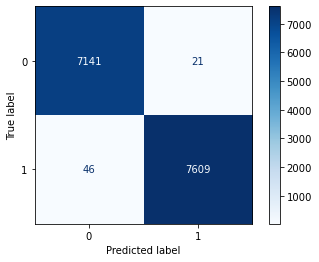

In [49]:
plot_confusion_matrix(lg_classifier, count_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [50]:
lg_classifier = LogisticRegression(max_iter=500)
lg_classifier.fit(tfidf_train, y_train)
pred_lg_tfidf = lg_classifier.predict(tfidf_test)
accuracy_score(y_test, pred_lg_tfidf)

0.985084700006749

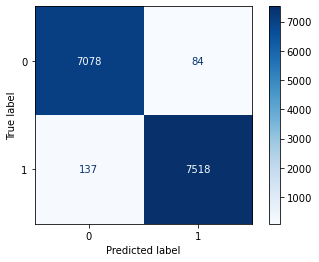

In [51]:
plot_confusion_matrix(lg_classifier, tfidf_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [12]:
'''# test on sample fake and real news
np.random.seed(7406)
sample_text_fake = np.random.choice(data.loc[data['class'] == 1]['text'], 1)[0]
sample_text_real = np.random.choice(data.loc[data['class'] == 0]['text'], 1)[0]'''

"# test on sample fake and real news\nnp.random.seed(7406)\nsample_text_fake = np.random.choice(data.loc[data['class'] == 1]['text'], 1)[0]\nsample_text_real = np.random.choice(data.loc[data['class'] == 0]['text'], 1)[0]"

In [13]:
'''sample_text_fake_token = word_tokenize(sample_text_fake)
# Retain alphabetic lower case words: alpha_only
alpha_only_fake = [t.lower() for t in sample_text_fake_token if t.isalpha()]

# Remove all stop words: no_stops
no_stops_fake = [t for t in alpha_only_fake if t not in stopwords.words('english')]
Counter(no_stops_fake)'''

"sample_text_fake_token = word_tokenize(sample_text_fake)\n# Retain alphabetic lower case words: alpha_only\nalpha_only_fake = [t.lower() for t in sample_text_fake_token if t.isalpha()]\n\n# Remove all stop words: no_stops\nno_stops_fake = [t for t in alpha_only_fake if t not in stopwords.words('english')]\nCounter(no_stops_fake)"